In [13]:
import pickle


def l2norm(list1, list2):
    l2_norm_difference = sum((x - y) ** 2 for x, y in zip(list1, list2)) ** 0.5
    l2_norm_reference = sum(y**2 for y in list1) ** 0.5
    return l2_norm_difference / l2_norm_reference


def get_record(cnum, dataset, model, setup):
    rec_path = f"./rec_fed_sample_time/{model}_model_{cnum}_{dataset}_{setup}.rec"
    with open(rec_path, "rb") as res_file:
        record = pickle.load(res_file)
    return record


In [ ]:
import os
import sys

from tqdm import tqdm
from helper_alg import IPSS_SHAP, TMC_SHAP, GTB_SHAP, CC_SHAP, CC_Weight_SHAP, DEF_SHAP

cnum = 10
dataset = "mnist"
model = "cnn"
setup = "noiseX"
setting = (cnum, dataset, model, setup)

record = get_record(cnum, dataset, model, setup)
exact = DEF_SHAP(record, cnum, False)[0]
sample_algs = {"Light Sampling": IPSS_SHAP, "Extended-TMC": TMC_SHAP, "Extended-GTB": GTB_SHAP, "CC-Shapley": CC_Weight_SHAP}
data_filepath = f"data/data_{cnum}_{model}_{dataset}_{setup}.pk"
data = {}

if os.path.exists(data_filepath):
    with open(data_filepath, "rb") as data_file:
        data = pickle.load(data_file)
    # for alg in sample_algs:
    #     if alg in ["Light Sampling", "CC-Shapley"]:
    #         tmp = []
    #         for gamma in tqdm(range(1, 2**cnum + 1), desc=alg):
    #             acc, loss, acc_time, loss_time = sample_algs[alg](record, cnum, gamma, False)
    #             tmp.append((gamma, acc_time, l2norm(exact, acc)))
    #         data[alg] = tmp
    # with open(data_filepath, "wb") as f:
    #     pickle.dump(data, f)
else:
    for alg in sample_algs:
        tmp = []
        error = []
        for gamma in tqdm(range(1, 2**cnum + 1), desc=alg):
            try:
                acc, loss, acc_time, loss_time = sample_algs[alg](record, cnum, gamma, False)
                tmp.append((gamma, acc_time, l2norm(exact, acc)))
            except:
                error.append(gamma)
        if error:
            print(f"Error in {alg} for gamma = {error}")
        data[alg] = tmp
    with open(data_filepath, "wb") as f:
        pickle.dump(data, f)

non_sample_algs = [alg for alg in data if alg not in sample_algs]

data

{'Comb-Shapley': (24589.93837080436, 0.0),
 'Perm-Shapley': (1762811582.8457558, 9.549155075389051e-12),
 'Extended-TMC': [(1, 31.62668250600109, 1.0),
  (2, 31.62668250600109, 1.0),
  (3, 31.62668250600109, 1.0),
  (4, 31.62668250600109, 1.0),
  (5, 31.62668250600109, 1.0),
  (6, 31.62668250600109, 1.0),
  (7, 31.62668250600109, 1.0),
  (8, 31.62668250600109, 1.0),
  (9, 31.62668250600109, 1.0),
  (10, 286.8213961129077, 2.919270509155102),
  (11, 286.18235056393314, 2.912897625690996),
  (12, 287.2130621721153, 2.9194209888306304),
  (13, 287.23932667204645, 2.9146039233736003),
  (14, 286.4810422100127, 2.9357860821708566),
  (15, 286.0402201481047, 2.928430531206839),
  (16, 286.3380974130705, 2.9358672522613802),
  (17, 286.3281577958842, 2.919245733776222),
  (18, 285.7639441639767, 2.8849998568079473),
  (19, 285.6845317510306, 2.9608360734750487),
  (20, 541.1063973669661, 1.9660208400919454),
  (21, 450.14701302110916, 1.947789068066418),
  (22, 478.34851763403276, 2.960844289

In [15]:
import matplotlib.pylab as plt

# plt.style.use("ggplot")
# plt.rcParams["axes.prop_cycle"]
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.rm"] = "Times New Roman"

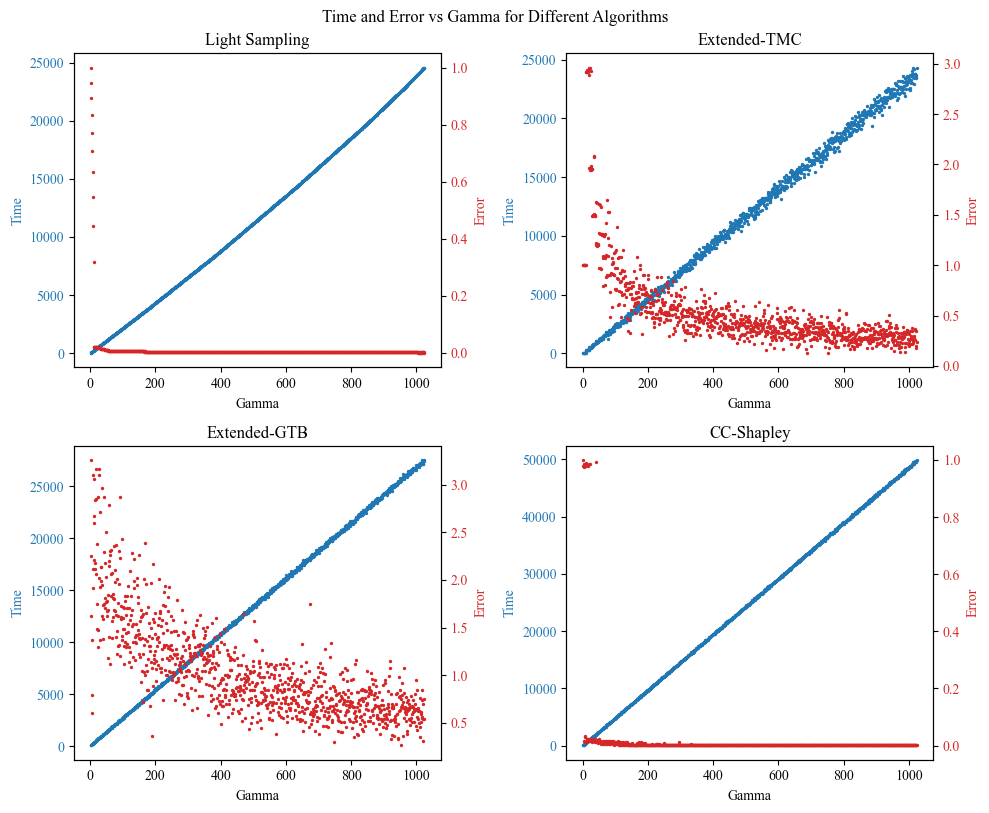

In [16]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
algorithms = list(sample_algs.keys())

for i, ax in enumerate(axes.flat):
    # Extract data for the current algorithm
    tmp = data[algorithms[i]]
    gamma = [r[0] for r in tmp]
    time = [r[1] for r in tmp]
    error = [r[2] for r in tmp]

    # Plot time on the left y-axis
    color = "tab:blue"
    ax.set_xlabel("Gamma")
    ax.set_ylabel("Time", color=color)
    ax.scatter(gamma, time, s=2, color=color, label="Time")
    ax.tick_params(axis="y", labelcolor=color)

    # Create a secondary y-axis for error
    ax2 = ax.twinx()
    color = "tab:red"
    ax2.set_ylabel("Error", color=color)
    ax2.scatter(gamma, error, s=2, color=color, label="Error")
    ax2.tick_params(axis="y", labelcolor=color)
    # ax2.set_ylim(0, 0.03)
    # ax2.set_yscale("log")

    # Add a title for each subplot
    ax.set_title(algorithms[i])

# Adjust layout to avoid overlap
fig.tight_layout()
plt.suptitle("Time and Error vs Gamma for Different Algorithms", y=1.01)
plt.show()

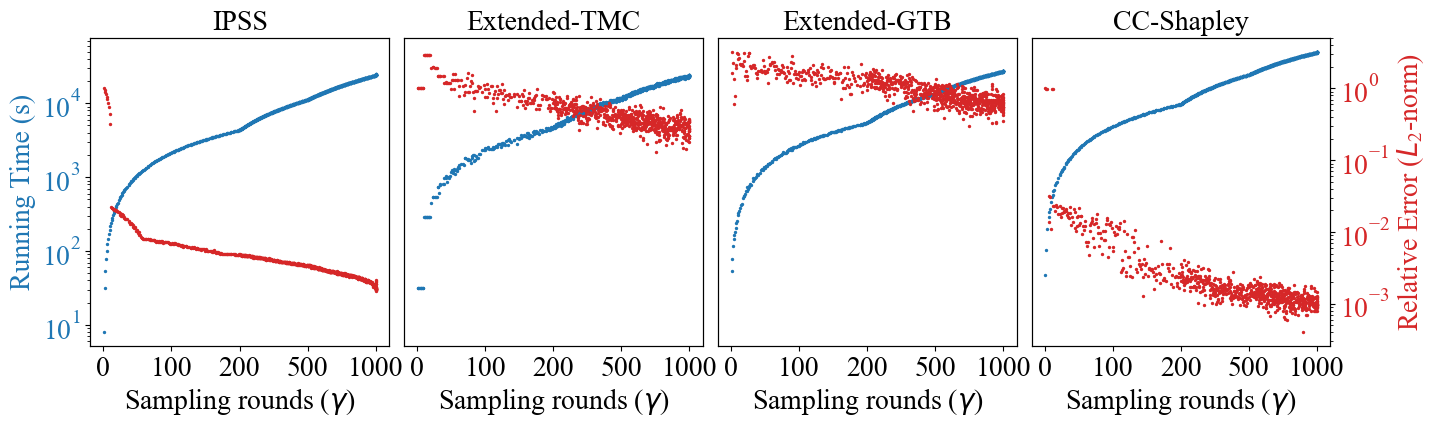

In [17]:
import matplotlib.pyplot as plt
import numpy as np

fontsize = 20
labelsize = 20


# 将原始数据映射到 [0, len(custom_ticks)-1] 区间，以便在等间距轴上显示
def map_to_custom_ticks(value, ticks, mapping="linear"):
    for i in range(len(ticks) - 1):
        if ticks[i] <= value < ticks[i + 1]:
            if mapping == "linear":
                return i + (value - ticks[i]) / (ticks[i + 1] - ticks[i])
            elif mapping == "log":
                return i + (np.log(value) - np.log(ticks[i])) / (np.log(ticks[i + 1]) - np.log(ticks[i]))
    return len(ticks) - 1  # 超出范围的点映射到最大刻度


def remove_local_outliers(data, window_size=5, threshold=3):
    """使用滑动窗口的中位数绝对偏差 (MAD) 过滤局部离群点"""
    data = np.array(data)
    filtered_data = data.copy()

    for i in range(len(data)):
        start = max(0, i - window_size // 2)
        end = min(len(data), i + window_size // 2 + 1)
        window = data[start:end]

        median = np.median(window)
        mad = np.median(np.abs(window - median))  # 计算 MAD

        # 过滤超出 threshold * MAD 的点
        if np.abs(data[i] - median) > threshold * mad:
            filtered_data[i] = np.nan  # 设为 NaN，稍后删除

    return filtered_data[~np.isnan(filtered_data)]  # 移除 NaN 作为离群点


fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)
axes: list[plt.Axes]
algorithms = list(sample_algs.keys())

# 创建右侧共享 Error 轴
ax2_list: list[plt.Axes] = [ax.twinx() for ax in axes]
for ax2 in ax2_list:
    ax2.sharey(ax2_list[0])  # 共享 Error 轴

for i, ax in enumerate(axes):
    # 获取数据
    tmp = data[algorithms[i]]
    gamma = np.array([r[0] for r in tmp])
    time = np.array([r[1] for r in tmp])
    error = np.array([r[2] for r in tmp])

    # 局部离群点过滤
    time_filtered = remove_local_outliers(time)
    error_filtered = remove_local_outliers(error)

    # 重新筛选符合条件的数据
    mask_time = np.isin(time, time_filtered)
    mask_error = np.isin(error, error_filtered)
    mask = mask_time & mask_error  # 仅保留同时符合两个条件的数据点

    gamma = gamma[mask]
    time = time[mask]
    error = error[mask]

    x_ticks = [0, 100, 200, 500, 1000]
    gamma = [map_to_custom_ticks(x, x_ticks, "linear") for x in gamma]
    ax.set_xticks(np.arange(len(x_ticks)))
    ax.set_xticklabels(x_ticks)

    # 左 y 轴 (Time) - log scale
    color = "tab:blue"
    ax.scatter(gamma, time, s=2, color=color, label="Time")
    ax.set_yscale("log")

    # 右 y 轴 (Error) - log scale
    color = "tab:red"
    ax2 = ax2_list[i]
    ax2.scatter(gamma, error, s=2, color=color, label="Error")
    ax2.set_yscale("log")
    # ax2.set_yscale("symlog", linthresh=1e-2)

    # 设置标题
    ax.set_xlabel("Sampling rounds ($\gamma$)", fontsize=fontsize)
    ax.tick_params(axis="x", labelsize=labelsize)
    ax.set_title(algorithms[i] if algorithms[i] != "Light Sampling" else "IPSS", fontsize=fontsize)

# 设置全局 y 轴标签（左侧）
axes[0].set_ylabel("Running Time (s)", color="tab:blue", fontsize=fontsize)
axes[0].tick_params(axis="y", labelcolor="tab:blue", labelsize=labelsize)

# 设置全局 y 轴标签（右侧）
ax2_list[-1].set_ylabel("Relative Error ($L_{2}$-norm)", color="tab:red", fontsize=fontsize)
ax2_list[-1].tick_params(axis="y", labelcolor="tab:red", labelsize=labelsize)
if setting == (10, "emnist", "linear", "same"):
    ax2_list[-1].set_yticks(
        [0.4, 0.6, 1, 2, 3],
        [
            "$\\mathdefault{4\\times 10^{-1}}$",
            "$\\mathdefault{6\\times 10^{-1}}$",
            "$\\mathdefault{10^{0}}$",
            "$\\mathdefault{2\\times 10^{0}}$",
            "$\\mathdefault{3\\times 10^{0}}$",
        ],
    )
    # ax2_list[-1].set_yticks([0.4, 0.6, 1, 2, 3], ["$\mathdefault{}$", 0.6, 1, 2, 3])

# 移除中间子图的 y 轴刻度
for ax in axes[1:]:
    ax.yaxis.set_visible(False)  # 隐藏中间子图的 Time 轴
for ax2 in ax2_list[:-1]:
    ax2.yaxis.set_visible(False)  # 隐藏中间子图的 Error 轴

# 缩小子图间距
fig.subplots_adjust(wspace=0.05)

# 设置总标题
# plt.suptitle(f"Time and Error vs Gamma ({dataset})", y=1.01)
plt.savefig(f"figs/sensitivity/sensitivity_{cnum}_{model}_{dataset}_{setup}.png", bbox_inches="tight")
plt.show()